### Frame of Problem:
Sensors are deployed on site to collect data. However, the data come with measurement error.  
* Sensors degrade over time. 
* Sensor measurement is subject to environmental factors. 

Suppose one would like to build a model, of which the dependent variable is the predicted true measure, the independent variables are reference sensors and envrionmental factors. This model captures the relationship among these variables when the sensor in question is in the normal state, under which condition the training data is collected.

Instead of deterministic models which output the point-wise prediction for calibration. Stochastic models are preferred here to measure uncertainties (both aleatoric uncertainty and epistemic uncertainty). They respectively refer to two challenges of on-site sensors mentioned before.

* After a peroid of time, the old model will no longer be able to reflect this relationship due to sensor degradation. This may be captured by low epistemic uncertainty (compared against aleatoric uncertainty) from the model prediction. In another word, the new observation comes as a surprise for the model even if it knows the input variables well. In this case, the model should raise a warning.
* In other cases, one would like to calibrate the sensor data on site by predicting the difference, when the retrieval of the sensors are out of the question.

There are two possible ways of making a neural network stochastic.
* Variational Bayesian by setting priors on the weights of a neural network. This can be difficult considering the large number of weights.
* Dropout / Ensemble. In this case, the neural network has to output both the mean and the standard variance (for the quantification of aleatoric uncertainty), of which the loss function must also include these two terms. The epistemic uncertainty is measured by the spread of the various predictions.

In our specific case, the sensor in question is the oxygen sensor from Node 1. The reference snesor is CTD. However, these two sensors are measure at different depths and thus different temperatures. This is also the case in most calibration scenarios where reference sensors and target sensers are in different places. 

The data is formed by joining CTD and Node 1. Further resampling could mitigate the issue of lack of data. Assuming that this data set is collected when sensors are in normal state. We would like to build a stochastic model to describe the relationship between node 1 oxygen sensor (as the dependent variable) and CTD oxygen sensor. CTD is expected to be the ground truth as it is more precise than Node 1. 

We would like to perform $2$ models $\times$ $2$ applications  $= 4$ experiments.

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import datetime
from tqdm import tqdm
import random

### Data Description
What is the data?
How the data is collected?

### Load Data

In [10]:
data_path = "data"

file_Conduvibilita = "TBaia_01m-Conducibilita'.txt"
file_CTD = "TBaia_01m-CTD.txt"
file_Ossigeno = "TBaia_01m-Ossigeno.txt"
file_Winkler = "TBaia_01m-Winkler.txt"

In [11]:
def convertTime(x):
    try:
        return pd.to_datetime(x["Data"] + "/" + x["Ora(UTC)"], format="%d/%m/%Y/%H:%M:%S")
    except:
        return -1

################### Conducibilita ###################
Conducibilita_raw_df = pd.read_csv(os.path.join(data_path, file_Conduvibilita), encoding='cp1252', header=None, skiprows=11)
Conducibilita_raw_df.iloc[0, 0] = re.sub("#", "", Conducibilita_raw_df.iloc[0, 0]).strip()
Conducibilita_raw_df = Conducibilita_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = Conducibilita_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = Conducibilita_raw_df.iloc[0, :]

Conducibilita_raw_df.columns = colNames
Conducibilita_raw_df = Conducibilita_raw_df.iloc[1:, :]

for j in range(2, Conducibilita_raw_df.shape[1]):
    Conducibilita_raw_df.iloc[:, j] = Conducibilita_raw_df.iloc[:, j].astype(np.float32)

Conducibilita_raw_df["Time"] = Conducibilita_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Conducibilita_raw_df["Data"] = Conducibilita_raw_df["Time"].dt.date
Conducibilita_raw_df["Ora(UTC)"] =  Conducibilita_raw_df["Time"].dt.time

################### CTD ###################

CTD_raw_df = pd.read_csv(os.path.join(data_path, file_CTD), encoding='cp1252', header=None, skiprows=15)
CTD_raw_df.iloc[0, 0] = re.sub("#", "", CTD_raw_df.iloc[0, 0]).strip()
CTD_raw_df = CTD_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = CTD_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = CTD_raw_df.iloc[0, :]

CTD_raw_df.columns = colNames
CTD_raw_df = CTD_raw_df.iloc[1:, :]

for j in range(2, CTD_raw_df.shape[1]):
    CTD_raw_df.iloc[:, j] = CTD_raw_df.iloc[:, j].astype(np.float32)

CTD_raw_df["Time"] = CTD_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
CTD_raw_df["Data"] = CTD_raw_df["Time"].dt.date
CTD_raw_df["Ora(UTC)"] =  CTD_raw_df["Time"].dt.time

################### Ossigeno ###################
Ossigeno_raw_df = pd.read_csv(os.path.join(data_path, file_Ossigeno), encoding='cp1252', header=None, skiprows=11)
Ossigeno_raw_df.iloc[0, 0] = re.sub("#", "", Ossigeno_raw_df.iloc[0, 0]).strip()
Ossigeno_raw_df = Ossigeno_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = Ossigeno_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = Ossigeno_raw_df.iloc[0, :]

Ossigeno_raw_df.columns = colNames
Ossigeno_raw_df = Ossigeno_raw_df.iloc[1:, :]

for j in range(2, Ossigeno_raw_df.shape[1]):
    Ossigeno_raw_df.iloc[:, j] = Ossigeno_raw_df.iloc[:, j].astype(np.float32)

Ossigeno_raw_df["Time"] = Ossigeno_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Ossigeno_raw_df["Data"] = Ossigeno_raw_df["Time"].dt.date
Ossigeno_raw_df["Ora(UTC)"] =  Ossigeno_raw_df["Time"].dt.time

################### Winkler ###################
Winkler_raw_df = pd.read_csv(os.path.join(data_path, file_Winkler), encoding='cp1252', header=None, skiprows=10)
Winkler_raw_df.iloc[0, 0] = re.sub("#", "", Winkler_raw_df .iloc[0, 0]).strip()
Winkler_raw_df = Winkler_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
colNames = Winkler_raw_df.iloc[0, :]
# colNames = Winkler_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])

Winkler_raw_df.columns = colNames
Winkler_raw_df = Winkler_raw_df.iloc[1:, :]

for j in range(2,  Winkler_raw_df.shape[1]):
    Winkler_raw_df.iloc[:, j] = Winkler_raw_df.iloc[:, j].astype(np.float32)

Winkler_raw_df["Time"] = Winkler_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Winkler_raw_df["Data"] = Winkler_raw_df["Time"].dt.date
Winkler_raw_df["Ora(UTC)"] =  Winkler_raw_df["Time"].dt.time

Ossigeno_na_df = Ossigeno_raw_df.where( Ossigeno_raw_df!=-9999, other=None )
Winkler_na_df = Winkler_raw_df.where( Winkler_raw_df!=-9999, other=None )
CTD_na_df = CTD_raw_df.where( CTD_raw_df!=-9999, other=None )
Conducibilita_na_df = Conducibilita_raw_df.where( Conducibilita_raw_df!=-9999, other=None)

In [12]:
Conducibilita_without_na_df = Conducibilita_na_df.dropna()
Ossigeno_without_na_df = Ossigeno_na_df.dropna(subset=["Ossigeno(mg/l)"])
Winkler_without_na_df = Winkler_na_df.dropna()
CTD_without_na_df = CTD_na_df.dropna(subset=["Ossigeno(mg/l)"])

In [13]:
Ossigeno_without_na_sub_df = Ossigeno_without_na_df[["Data", "Ora(UTC)", "Pressione(db)", "Ossigeno(mg/l)", "Temperatura(°C)", "Time"]]
CTD_without_na_sub_df = CTD_without_na_df[["Data", "Ora(UTC)", "Pressione(db)", "Ossigeno(mg/l)", "Temperatura(°C)", "Time"]]

Oxygen sensor data is collecte every half an hour, while CTD sensor data is collected every week. We would like to resample CTD data so that they match frequencies.

In [14]:
Ossigeno_without_na_sub_df.head()

,Data,Ora(UTC),Pressione(db),Ossigeno(mg/l),Temperatura(°C),Time
1,2021-10-06,10:26:55,0.624,6.58,22.080000,2021-10-06 10:26:55
2,2021-10-06,11:00:33,0.763,6.58,22.049999,2021-10-06 11:00:33
3,2021-10-06,11:30:34,0.714,6.66,22.030001,2021-10-06 11:30:34
4,2021-10-06,12:00:33,0.684,6.67,22.010000,2021-10-06 12:00:33
5,2021-10-06,12:30:33,0.664,6.72,22.010000,2021-10-06 12:30:33


In [15]:
CTD_without_na_sub_df.head()

,Data,Ora(UTC),Pressione(db),Ossigeno(mg/l),Temperatura(°C),Time
2,2021-03-31,08:38:00,1.019,7.797,14.8473,2021-03-31 08:38:00
3,2021-04-07,08:38:00,0.988,7.730,14.7488,2021-04-07 08:38:00
4,2021-04-14,09:00:00,0.913,8.082,14.0465,2021-04-14 09:00:00
5,2021-04-21,09:00:00,0.840,8.052,14.9393,2021-04-21 09:00:00
6,2021-04-28,08:20:00,0.770,7.918,15.7893,2021-04-28 08:20:00


In [16]:
# Ossigeno_without_na_sub_df["Year"] = Ossigeno_without_na_sub_df["Data"].apply(lambda x: x.isocalendar().year)

In [17]:
# Ossigeno_without_na_sub_df["Week"] = Ossigeno_without_na_sub_df["Data"].apply(lambda x: x.isocalendar().week)

In [18]:
# data_counts_df = Ossigeno_without_na_sub_df.groupby(["Year", "Week"]).count().reset_index()[["Data", "Year", "Week"]].rename({"Data": "counts"}, axis=1)

In [19]:
# CTD_without_na_sub_df["Year"] = CTD_without_na_sub_df["Data"].apply(lambda x: x.isocalendar().year)
# CTD_without_na_sub_df["Week"] = CTD_without_na_sub_df["Data"].apply(lambda x: x.isocalendar().week)

In [20]:
def round_time(x):
    minute = int(round(x.minute / 30)*30)
    if minute == 60:
        if x.hour == 23:
            try:
                x = x.replace(minute=0, hour=0, day=x.day+1)
            except:
                try:
                    x = x.replace(minute=0, hour=0, day=1, month=x.month+1)
                except:
                    x = x.replace(minute=0, hour=0, day=1, month=1, year=x.year+1)
                
        else:
            x = x.replace(minute=0, hour=x.hour+1)
    else:
        x = x.replace(minute=minute)
    x = x.replace(second=0)
    return x

In [21]:
Ossigeno_without_na_sub_df["Time_rounded"] = Ossigeno_without_na_sub_df["Time"]
CTD_without_na_sub_df["Time_rounded"] = CTD_without_na_sub_df["Time"] 
Ossigeno_without_na_sub_df["Time_rounded"] = Ossigeno_without_na_sub_df["Time_rounded"].apply(lambda x: round_time(x))
CTD_without_na_sub_df["Time_rounded"] = CTD_without_na_sub_df["Time_rounded"].apply(lambda x: round_time(x))

/tmp/ipykernel_293094/1630497422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ossigeno_without_na_sub_df["Time_rounded"] = Ossigeno_without_na_sub_df["Time"]
/tmp/ipykernel_293094/1630497422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTD_without_na_sub_df["Time_rounded"] = CTD_without_na_sub_df["Time"]
/tmp/ipykernel_293094/1630497422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [22]:
CTD_Ossigeno_df = CTD_without_na_sub_df.merge(Ossigeno_without_na_sub_df, on="Time_rounded", how="right", suffixes=("_CTD", "_Ossigeno"))
CTD_Ossigeno_df = CTD_Ossigeno_df[["Time_rounded", "Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno", "Ossigeno(mg/l)_Ossigeno"]]
CTD_Ossigeno_df = CTD_Ossigeno_df.sort_values(by="Time_rounded", ascending=True)
CTD_Ossigeno_df["Temperatura(°C)_CTD"] = CTD_Ossigeno_df["Temperatura(°C)_CTD"].interpolate(method="linear")
CTD_Ossigeno_df["Pressione(db)_CTD"] = CTD_Ossigeno_df["Pressione(db)_CTD"].interpolate(method="linear")
CTD_Ossigeno_df["Ossigeno(mg/l)_CTD"] = CTD_Ossigeno_df["Ossigeno(mg/l)_CTD"].interpolate(method="linear")
CTD_Ossigeno_df = CTD_Ossigeno_df.dropna()

In [184]:
CTD_Ossigeno_df

,Time_rounded,Temperatura(°C)_CTD,Pressione(db)_CTD,Ossigeno(mg/l)_CTD,Temperatura(°C)_Ossigeno,Pressione(db)_Ossigeno,Ossigeno(mg/l)_Ossigeno
43,2021-10-07 08:30:00,21.628300,1.002000,6.367000,21.540001,0.912,6.34
44,2021-10-07 09:00:00,21.623821,1.002239,6.370302,21.680000,0.882,6.36
45,2021-10-07 09:30:00,21.619343,1.002477,6.373604,21.680000,0.872,6.34
46,2021-10-07 10:00:00,21.614864,1.002716,6.376905,21.680000,0.892,6.36
47,2021-10-07 10:30:00,21.610386,1.002954,6.380207,21.740000,0.882,6.34
...,...,...,...,...,...,...,...
7382,2022-03-31 12:00:00,13.647500,0.686000,8.446600,13.830000,0.882,8.33
7383,2022-03-31 12:30:00,13.647500,0.686000,8.446600,14.150000,0.981,8.25
7384,2022-03-31 13:00:00,13.647500,0.686000,8.446600,14.110000,0.872,8.27
7385,2022-03-31 13:30:00,13.647500,0.686000,8.446600,14.050000,0.872,8.28


In order to have more observations, we would like to resample the data. For indenpendent variables, the uncertainties are known, and thus the resampling is possible. On the contrary, for the dependent variable, the resampling is impossible, so we keep it as it is.



In [24]:
# from functools import partial

In [25]:
# scale_CTD_temp = 0.023
# scale_CTD_press = 0.24
# relative_scale_CTD_oxyg = 0.02

# scale_node1_temp = 0.15
# scale_node1_press = 2
# relative_scale_node1_oxyg = 0.052

# augFunc_CTD_temp = partial(np.random.normal, scale=scale_CTD_temp)
# augFunc_CTD_press = partial(np.random.normal, scale=scale_CTD_press)
# augFunc_CTD_oxyg = lambda x: x * np.random.uniform(low=1-relative_scale_CTD_oxyg, high=1+relative_scale_CTD_oxyg)

# augFunc_node1_temp = lambda x: x + np.random.uniform(low=-scale_node1_temp, high=scale_node1_temp)
# augFunc_node1_press = lambda x: x + np.random.uniform(low=-scale_node1_press, high=scale_node1_press)
# augFunc_node1_oxyg = lambda x: x * np.random.uniform(low=-relative_scale_node1_oxyg, high=relative_scale_node1_oxyg)

In [26]:
# def resample(df, n=1):
#     import pandas as pd
    
#     resampled_df = pd.DataFrame([
#         df["Temperatura(°C)_CTD"].apply(lambda x: augFunc_CTD_temp(x)),
#                                      df["Pressione(db)_CTD"].apply(lambda x: augFunc_CTD_press(x)),
#                                      df["Ossigeno(mg/l)_CTD"].apply(lambda x: augFunc_CTD_oxyg(x)),

#                                      df["Temperatura(°C)_Ossigeno"].apply(lambda x: augFunc_node1_temp(x)),
#                                      df["Pressione(db)_Ossigeno"].apply(lambda x: augFunc_node1_press(x)),
#                                      df["Ossigeno(mg/l)_Ossigeno"].apply(lambda x: augFunc_node1_oxyg(x))]).T
#     # resampled_df = pd.concat(resampled_df_ls, axis=0, ignore_index=True)
#     return resampled_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]], resampled_df[["Ossigeno(mg/l)_Ossigeno"]]

In [27]:
# gen = partial(resample, df=CTD_Ossigeno_df)

In [28]:
# c = tf.data.Dataset.from_generator(gen, output_signature=(
#          tf.TensorSpec(shape=(22, 5), dtype=tf.float64),
#          tf.TensorSpec(shape=(22, 1), dtype=tf.float64)))

### Data Visualization

### Model

In [29]:
import tensorflow as tf

2022-09-25 09:38:46.279103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-25 09:38:46.279157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


##### Deterministic

In [58]:
model_deterministic = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(5, )),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
model_deterministic.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [59]:
model_deterministic.fit(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]], CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]], batch_size=32, epochs=250)

Epoch 1/250
228/228 [==============================] - 3s 5ms/step - loss: 6.7704 - mae: 1.8995
Epoch 2/250
228/228 [==============================] - 1s 5ms/step - loss: 2.1864 - mae: 1.1792
Epoch 3/250
228/228 [==============================] - 1s 5ms/step - loss: 1.8758 - mae: 1.0940
Epoch 4/250
228/228 [==============================] - 1s 6ms/step - loss: 1.7875 - mae: 1.0725
Epoch 5/250
228/228 [==============================] - 1s 5ms/step - loss: 1.7179 - mae: 1.0459
Epoch 6/250
228/228 [==============================] - 1s 5ms/step - loss: 1.5669 - mae: 1.0006
Epoch 7/250
228/228 [==============================] - 1s 6ms/step - loss: 1.5254 - mae: 0.9849
Epoch 8/250
228/228 [==============================] - 1s 5ms/step - loss: 1.5151 - mae: 0.9814
Epoch 9/250
228/228 [==============================] - 1s 4ms/step - loss: 1.4101 - mae: 0.9516
Epoch 10/250
228/228 [==============================] - 1s 5ms/step - loss: 1.3341 - mae: 0.9219
Epoch 11/250
228/228 [=================

In [61]:
import matplotlib.pyplot as plt

In [64]:
y_pred = model_deterministic.predict(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]])

228/228 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'Deterministic Model without Noise Estimation')

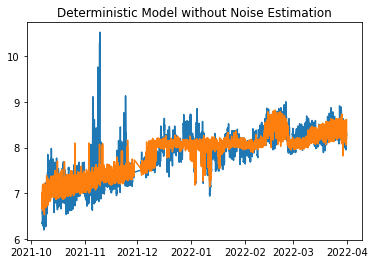

In [89]:
plt.plot(CTD_Ossigeno_df["Time_rounded"], CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]])
plt.plot(CTD_Ossigeno_df["Time_rounded"], y_pred)
plt.title("Deterministic Model without Noise Estimation")

Text(0.5, 1.0, 'MC Dropout Single Run')

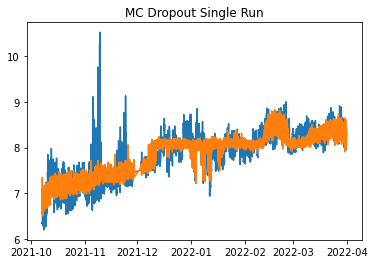

In [90]:
tf.random.set_seed(221)
y_pred = model_deterministic(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]].to_numpy(), training=True)
plt.plot(CTD_Ossigeno_df["Time_rounded"], CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]])
plt.plot(CTD_Ossigeno_df["Time_rounded"], y_pred)
plt.title("MC Dropout Single Run")

In [103]:
tf.random.set_seed(221)
y_preds_ls = []
for i in range(100):
    y_pred = model_deterministic(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]].to_numpy(), training=True)
    y_preds_ls.append(y_pred.numpy())

Text(0.5, 1.0, 'MC Dropout with Predictive Uncertainty')

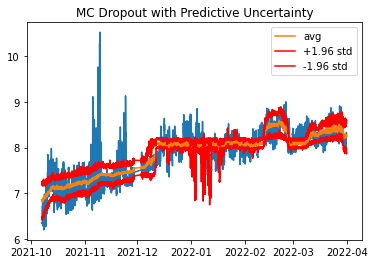

In [116]:
plt.plot(CTD_Ossigeno_df["Time_rounded"], CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]])
plt.plot(CTD_Ossigeno_df["Time_rounded"], np.mean(y_preds_ls, axis=0), label="avg")
plt.plot(CTD_Ossigeno_df["Time_rounded"], np.mean(y_preds_ls, axis=0) +  np.std(y_preds_ls, axis=0) * 1.96, color="red", label="+1.96 std")
plt.plot(CTD_Ossigeno_df["Time_rounded"], np.mean(y_preds_ls, axis=0) -  np.std(y_preds_ls, axis=0) * 1.96, color="red", label="-1.96 std")
plt.legend()
plt.title("MC Dropout with Predictive Uncertainty")

In [ ]:
model_deterministic = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(5, )),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
model_deterministic.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [123]:
tf.keras.Model

keras.engine.training.Model

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [269]:
# class Mean_Var(torch.nn.Module):

#     def __init__(self):
#         super(Mean_Var, self).__init__()

#         self.linear1 = nn.Linear(5, 128)
#         self.activation = nn.ReLU()
#         self.dropout1 = nn.Dropout(p=.2)
#         self.linear2 = nn.Linear(128, 64)
#         self.dropout2 = nn.Dropout(p=.2)
#         self.linear3 = nn.Linear(64, 32)
#         self.dropout3 = nn.Dropout(p=.2)
#         self.linear4 = nn.Linear(32, 1)
        
#         self.linear3_var = nn.Linear(64, 32)
#         self.dropout3_var = nn.Dropout(p=.2)
#         self.linear4_var = nn.Linear(32, 1)
        
#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.activation(x)
#         x = self.dropout1(x)
        
#         x = self.linear2(x)
#         x = self.activation(x)
#         x = self.dropout2(x)
        
#         x1 = self.linear3(x)
#         x1 = self.activation(x1)
#         x1 = self.dropout3(x1)
#         x1 = self.linear4(x1)
        
#         x2 = self.linear3_var(x)
#         x2 = self.activation(x2)
#         x2 = self.dropout3_var(x2)
#         x2 = self.linear4_var(x2)
        
        
#         return x1, x2
    
# model = Mean_Var()

# input_tensor = torch.tensor(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]].to_numpy())
# output_tensor = torch.tensor(CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]].to_numpy())

# optimizer = optim.SGD(model.parameters(), lr=0.01)

# n_epoch=2000
# for epoch in range(n_epoch):
#     optimizer.zero_grad()

#     output1, output2 = model(input_tensor)
#     loss = torch.square(output_tensor - output1)
#     loss = loss / torch.square(output2) + torch.log(torch.square(output2))
#     loss = loss.mean()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
#     optimizer.step()
#     print(loss)

In [290]:
# class DeepNormal(nn.Module):

#     def __init__(self, n_inputs, n_hidden):
#         super().__init__()

#         # Shared parameters
#         self.shared_layer = nn.Sequential(
#             nn.Linear(n_inputs, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(.2),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(.2),
#         )
        
#         # Mean parameters
#         self.mean_layer = nn.Sequential(
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(.2),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(.2),
            
#             nn.Linear(n_hidden, 1),
#         )
        
#         # Standard deviation parameters
#         self.std_layer = nn.Sequential(
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(.2),
#             nn.Linear(n_hidden, 1),
#             nn.Softplus(),  # enforces positivity
#         )
             
#     def forward(self, x):
#         # Shared embedding
#         shared = self.shared_layer(x)
        
#         # Parametrization of the mean
#         μ = self.mean_layer(shared)
        
#         # Parametrization of the standard deviation
#         σ = self.std_layer(shared)
        
#         return torch.distributions.Normal(μ, σ)
    
# def compute_loss(model, x, y):
#     normal_dist = model(x)
#     neg_log_likelihood = -normal_dist.log_prob(y)
#     return torch.mean(neg_log_likelihood)

In [293]:
# model = DeepNormal(n_inputs=5, n_hidden=512)

In [294]:
# n_epoch=2000
# for epoch in range(n_epoch):
#     optimizer.zero_grad()

#     loss = compute_loss(model, input_tensor, output_tensor)
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
#     optimizer.step()
#     print(loss)

tensor(66.4192, grad_fn=<MeanBackward0>)
tensor(66.4713, grad_fn=<MeanBackward0>)
tensor(66.5340, grad_fn=<MeanBackward0>)
tensor(66.3411, grad_fn=<MeanBackward0>)
tensor(65.8219, grad_fn=<MeanBackward0>)
tensor(65.9861, grad_fn=<MeanBackward0>)
tensor(66.6378, grad_fn=<MeanBackward0>)
tensor(66.3545, grad_fn=<MeanBackward0>)
tensor(66.4051, grad_fn=<MeanBackward0>)
tensor(66.2761, grad_fn=<MeanBackward0>)
tensor(66.3530, grad_fn=<MeanBackward0>)
tensor(66.0764, grad_fn=<MeanBackward0>)
tensor(66.4634, grad_fn=<MeanBackward0>)
tensor(65.8261, grad_fn=<MeanBackward0>)
tensor(65.9951, grad_fn=<MeanBackward0>)
tensor(66.3130, grad_fn=<MeanBackward0>)
tensor(67.2916, grad_fn=<MeanBackward0>)
tensor(66.4815, grad_fn=<MeanBackward0>)
tensor(66.7628, grad_fn=<MeanBackward0>)
tensor(66.2917, grad_fn=<MeanBackward0>)
tensor(66.1151, grad_fn=<MeanBackward0>)
tensor(66.1367, grad_fn=<MeanBackward0>)
tensor(66.3401, grad_fn=<MeanBackward0>)
tensor(66.2241, grad_fn=<MeanBackward0>)
tensor(67.0063, 

KeyboardInterrupt: 

##### Variational Bayes

For this variational bayesian neural netowrk, the final output is a normal distribution characterized by mean and standard deviation. This output can be sampled. They are expressed respectively by the values of two neurons. The weights and biases that link these two neruons to the previous layer is stochastic. The priors of the weights conform to independent normal distribution characterized by standard deviation 1 and location as trainable variables. The posterior of the weight conform to independent distributions with both trainable means and standard deviations.

In [295]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [296]:
shape = CTD_Ossigeno_df.shape[0]

In [297]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
          tfp.layers.VariableLayer(n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t, scale=1),
              reinterpreted_batch_ndims=1)),
  ])

In [298]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [299]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(5, )),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
    
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/shape),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])


In [300]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]], CTD_Ossigeno_df[["Ossigeno(mg/l)_Ossigeno"]], batch_size=shape, epochs=3000)

Epoch 1/3000
1/1 [==============================] - 3s 3s/step - loss: 11.1846
Epoch 2/3000
1/1 [==============================] - 0s 13ms/step - loss: 577.3126
Epoch 3/3000
1/1 [==============================] - 0s 16ms/step - loss: 95.7390
Epoch 4/3000
1/1 [==============================] - 0s 11ms/step - loss: 181.6648
Epoch 5/3000
1/1 [==============================] - 0s 12ms/step - loss: 42.6020
Epoch 6/3000
1/1 [==============================] - 0s 17ms/step - loss: 164.0882
Epoch 7/3000
1/1 [==============================] - 0s 13ms/step - loss: 17.1783
Epoch 8/3000
1/1 [==============================] - 0s 15ms/step - loss: 445.5441
Epoch 9/3000
1/1 [==============================] - 0s 11ms/step - loss: 142.7778
Epoch 10/3000
1/1 [==============================] - 0s 11ms/step - loss: 9.1790
Epoch 11/3000
1/1 [==============================] - 0s 12ms/step - loss: 189.1328
Epoch 12/3000
1/1 [==============================] - 0s 11ms/step - loss: 280.5357
Epoch 13/3000
1/1 [==

This output is a distribution that can be sampled. The distributions of the mean indicate epistemic uncertainty. The standard deivation around a given mean is aleatoric uncertainty.

In [301]:
distri_output = model(CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]].to_numpy())

In [302]:
x_tst = CTD_Ossigeno_df[["Temperatura(°C)_CTD", "Pressione(db)_CTD", "Ossigeno(mg/l)_CTD", "Temperatura(°C)_Ossigeno", "Pressione(db)_Ossigeno"]].to_numpy()

In [303]:
n_predictions = 1

Text(0.5, 1.0, 'aleatoric uncertainty')

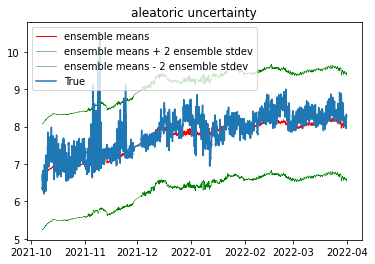

In [304]:
yhats = [model(x_tst) for _ in range(n_predictions)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(CTD_Ossigeno_df["Time_rounded"], m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(CTD_Ossigeno_df["Time_rounded"], m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(CTD_Ossigeno_df["Time_rounded"], m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
        plt.plot(CTD_Ossigeno_df["Time_rounded"], CTD_Ossigeno_df["Ossigeno(mg/l)_Ossigeno"], label="True")
        avgm += m
plt.legend()
plt.title("aleatoric uncertainty")
# plt.plot(x_tst[..., 0], avgm/len(yhats), 'r', label='overall mean', linewidth=4)

# plt.ylim(-0.,17);
# plt.yticks(np.linspace(0, 15, 4)[1:]);
# # plt.xticks(np.linspace(*x_range, num=9));

# ax=plt.gca();
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
# ax.spines['left'].set_position(('data', 0))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# #ax.spines['left'].set_smart_bounds(True)
# #ax.spines['bottom'].set_smart_bounds(True)
# plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [311]:
n_predictions = 100

Text(0.5, 1.0, 'epistemic uncertainty')

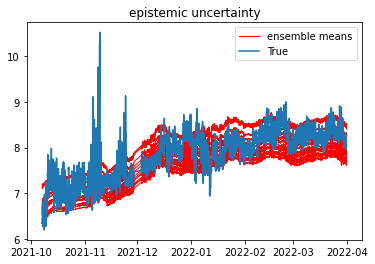

In [312]:
yhats = [model(x_tst) for _ in range(n_predictions)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(CTD_Ossigeno_df["Time_rounded"], m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)

        avgm += m
plt.plot(CTD_Ossigeno_df["Time_rounded"], CTD_Ossigeno_df["Ossigeno(mg/l)_Ossigeno"], label="True")
plt.legend()
plt.title("epistemic uncertainty")

Text(0.5, 1.0, 'epistemic uncertainty')

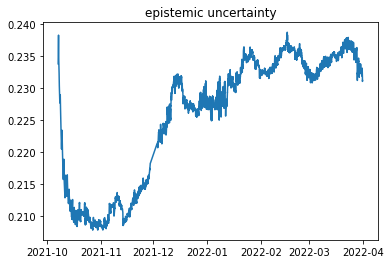

In [324]:
plt.plot(CTD_Ossigeno_df["Time_rounded"], np.std([yhat.mean().numpy() for yhat in yhats], axis=0))
plt.title("epistemic uncertainty")

Text(0.5, 1.0, 'aleatoric uncertainty')

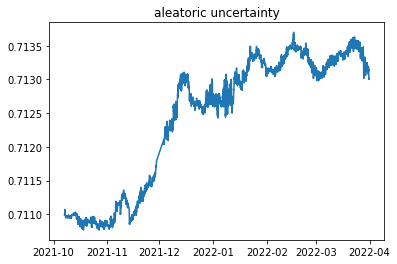

In [328]:
plt.plot(CTD_Ossigeno_df["Time_rounded"], np.mean([yhat.stddev().numpy() for yhat in yhats], axis=0))
plt.title("aleatoric uncertainty")

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

2022-08-26 11:28:26.312156: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-26 11:28:26.317407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 11:28:26.317422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
y = CTD_Ossigeno_df["Ossigeno(mg/l)_Ossigeno"]

In [26]:
x = CTD_Ossigeno_df[["Pressione(db)_Ossigeno", "Temperatura(°C)_Ossigeno", "Pressione(db)_CTD", "Temperatura(°C)_CTD", "Ossigeno(mg/l)_CTD"]]
x = np.array(x)

###　Resample

In [41]:
# np.random.normal(loc=x, scale=[0,1,2,3,4])

array([[ 0.912     , 20.49112839,  0.49378327, 18.74953517, 11.8083835 ],
       [ 0.90200001, 20.32963856,  3.21273826, 13.82130597,  4.31615314],
       [ 1.22899997, 19.14728031,  1.5801141 , 19.27796048, 10.81803086],
       [ 1.16900003, 19.53262296,  1.86164549, 16.78237978,  4.74369094],
       [ 1.04999995, 18.74898355,  0.09744468, 18.96799608,  1.24719882],
       [ 1.20899999, 17.27273657, -3.12269999, 13.11458863,  0.14027652],
       [ 1.16900003, 15.5789784 , -0.04286241, 18.03539069,  5.48177155],
       [ 1.11000001, 15.12696743,  0.26285264, 19.15326162,  5.48764438],
       [ 1.08000004, 13.72188943,  2.49685117,  8.55727772, 10.25771188],
       [ 1.31799996, 12.60086924,  0.16915653, 10.2246093 ,  5.68018141],
       [ 1.20899999, 16.39348773,  2.32892965, 11.18354168,  6.03936843],
       [ 1.18900001, 11.82144682,  3.36217253, 12.68243973,  6.84587664],
       [ 1.29799998, 12.93111661,  4.50341988, 13.11772371,  9.19606839],
       [ 1.33800006, 12.11226365,  1.5

In [ ]:
# negloglik = lambda y, p_y: -p_y.log_prob(y)

# # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
# def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
#     n = kernel_size + bias_size
#     c = np.log(np.expm1(1.))
#     return tf.keras.Sequential([
#           tfp.layers.VariableLayer(2 * n, dtype=dtype),
#           tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#               tfd.Normal(loc=t[..., :n],
#                          scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
#               reinterpreted_batch_ndims=1)),
#   ])
    
#     # Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
# def prior_trainable(kernel_size, bias_size=0, dtype=None):
#     n = kernel_size + bias_size
#     return tf.keras.Sequential([
#       tfp.layers.VariableLayer(n, dtype=dtype),
#       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#           tfd.Normal(loc=t, scale=1),
#           reinterpreted_batch_ndims=1)),
#   ])

# # Build model.
# # Build model.
# model = tf.keras.Sequential([
#   tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
#   tfp.layers.DistributionLambda(
#       lambda t: tfd.Normal(loc=t[..., :1],
#                            scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
# ])

# # Do inference.
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
# model.fit(x, y, epochs=10000, verbose=True);

# # Profit.
# [print(np.squeeze(w.numpy())) for w in model.weights];

Epoch 1/10000


2022-08-26 11:28:56.890098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.890250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.890359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.909914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.910075: W tensorflow/stream_executor/platform/default/dso_loader

1/1 [==============================] - 1s 1s/step - loss: 160.9226
Epoch 2/10000
1/1 [==============================] - 0s 6ms/step - loss: 23.1279
Epoch 3/10000
1/1 [==============================] - 0s 7ms/step - loss: 315.2360
Epoch 4/10000
1/1 [==============================] - 0s 6ms/step - loss: 627.6431
Epoch 5/10000
1/1 [==============================] - 0s 6ms/step - loss: 115.0773
Epoch 6/10000
1/1 [==============================] - 0s 7ms/step - loss: 2666.0496
Epoch 7/10000
1/1 [==============================] - 0s 7ms/step - loss: 311.2620
Epoch 8/10000
1/1 [==============================] - 0s 7ms/step - loss: 1237.9594
Epoch 9/10000
1/1 [==============================] - 0s 7ms/step - loss: 57.4669
Epoch 10/10000
1/1 [==============================] - 0s 7ms/step - loss: 15.6830
Epoch 11/10000
1/1 [==============================] - 0s 7ms/step - loss: 214.8833
Epoch 12/10000
1/1 [==============================] - 0s 6ms/step - loss: 6.2645
Epoch 13/10000
1/1 [===========